L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en deux parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [2]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
import matplotlib.pyplot as plt
import os
import pylab
import seaborn


#%matplotlib notebook

chemin = os.getcwd() + "/315 80 R 22.5.txt"
mat = np.loadtxt(chemin)
z = mat[:,0]   # N
p  = mat[:,1]   # Bar
dz = mat[:,2]   # N/°

Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

In [3]:
# Affichage des Mesures 
print(z.shape, p.shape, dz.shape)
print(dz)

(21,) (21,) (21,)
[1557.64 3237.7  4438.22 4961.65 5287.09 5448.14 5460.77 1399.18 2950.42
 4140.05 4760.91 5212.09 5572.68 5788.68 1320.73 2799.98 3963.98 4590.18
 5119.2  5516.78 5839.33]


In [4]:
print(z)

[11736. 25447. 39179. 48986. 58788. 68591. 78373. 11730. 25454. 39178.
 49003. 58799. 68603. 78363. 11734. 25463. 39198. 49004. 58790. 68606.
 78402.]


In [5]:
print(p)

[6.98 7.   6.99 6.99 6.98 6.99 7.01 8.46 8.49 8.49 8.47 8.49 8.48 8.51
 9.4  9.42 9.45 9.47 9.47 9.48 9.49]


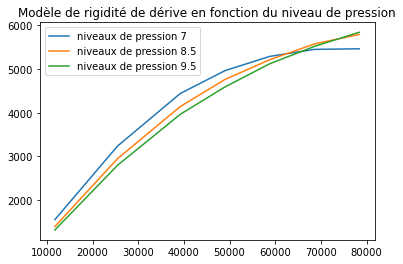

In [6]:
for palier in range(3):
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
plt.title("Modèle de rigidité de dérive en fonction du niveau de pression")
plt.legend(["niveaux de pression 7", "niveaux de pression 8.5", "niveaux de pression 9.5"])
plt.show()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

#### Arcsin est défini entre -1 et 1 donc a1*P + a2 est défini entre ....

In [7]:
# Estimation initiale de a1 et a2
a1 = 160
a2 = 4500

In [8]:
for palier in range(3):
    print(max(z[7*palier:7*(palier+1)]/np.tan(np.arcsin(dz[7*palier:7*(palier+1)]/(a1*p[7*palier:7*(palier+1)] + a2))/3)))

164900.291668797
153900.04290313734
168459.92817215982


In [9]:
a3 = 2
# Estimation initiale de a4 et a5  
# 

a4 = -7300
a5 = 216000

Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [10]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz 


def pacejka(x,a1,a2,a3,a4,a5):
    P = x[0]
    Fz = x[1]
    return (a1*P + a2)*np.sin(2*np.arctan(np.divide(Fz,(a4*P + a5))))

#Implémentation de Pacejka

In [11]:
y1 =  pacejka([p,z],a1,a2,a3,a4,a5)

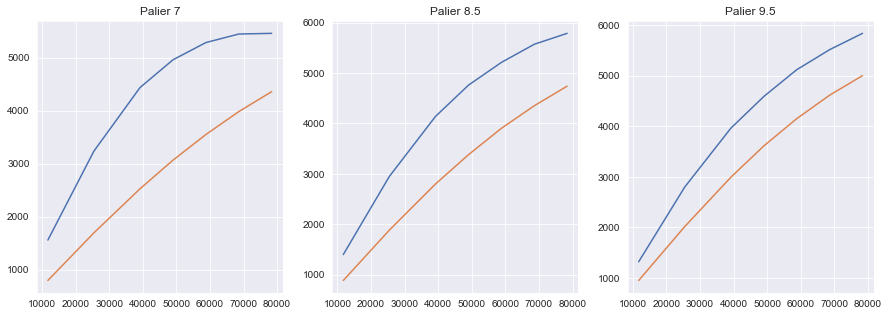

In [12]:
# Affichage de la superposition mesures/prédictions

o = [7,8.5,9.5]

seaborn.set({"figure.figsize": (15, 5)})
for palier in range(3):
    pylab.subplot(1,3,palier+1)
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y1[7*palier:7*(palier+1)])
    plt.title(f"Palier {o[palier]}")
plt.show()

### Calcul des performances

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
print("L'erreur est de ", mean_squared_error(dz, y1))

L'erreur est de  1480208.4593464676


### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

On va mettre en place un algorithme de régression linéaire

In [15]:
from scipy.optimize import curve_fit

In [16]:
# Regroupement les entrées dans une matrice 
X_data = np.array([p,z])

In [17]:
X_data

array([[6.9800e+00, 7.0000e+00, 6.9900e+00, 6.9900e+00, 6.9800e+00,
        6.9900e+00, 7.0100e+00, 8.4600e+00, 8.4900e+00, 8.4900e+00,
        8.4700e+00, 8.4900e+00, 8.4800e+00, 8.5100e+00, 9.4000e+00,
        9.4200e+00, 9.4500e+00, 9.4700e+00, 9.4700e+00, 9.4800e+00,
        9.4900e+00],
       [1.1736e+04, 2.5447e+04, 3.9179e+04, 4.8986e+04, 5.8788e+04,
        6.8591e+04, 7.8373e+04, 1.1730e+04, 2.5454e+04, 3.9178e+04,
        4.9003e+04, 5.8799e+04, 6.8603e+04, 7.8363e+04, 1.1734e+04,
        2.5463e+04, 3.9198e+04, 4.9004e+04, 5.8790e+04, 6.8606e+04,
        7.8402e+04]])

In [18]:
coeff = np.array([a1,a2,a3,a4,a5])
print(coeff)

[   160   4500      2  -7300 216000]


In [19]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser

approx = curve_fit(pacejka, X_data, dz, p0 = coeff)[0]

C:\Users\thoma\Anaconda3\envs\Michelin\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [20]:
# Optimisation des paramètres
approx

array([ 2.48676249e+02,  3.74853905e+03,  2.00000000e+00,  1.18507391e+04,
       -5.23303124e+03])

In [21]:
y2 = pacejka([p,z],approx[0],approx[1],approx[2],approx[3],approx[4])

Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

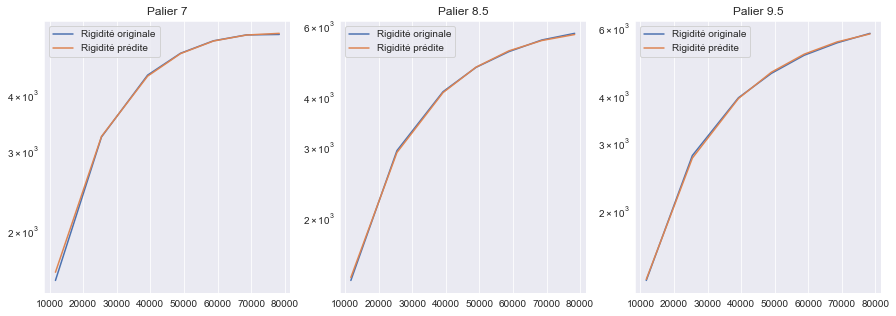

In [41]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

o = [7,8.5,9.5]

seaborn.set({"figure.figsize": (15, 5)})
for palier in range(3):
    pylab.subplot(1,3,palier+1)
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y2[7*palier:7*(palier+1)])
    plt.title(f"Palier {o[palier]}")
    plt.legend(["Rigidité originale", "Rigidité prédite"])
    plt.yscale('log')
plt.show()

In [23]:
print("L'erreur est de ", mean_squared_error(dz, y2))

L'erreur est de  754.9601962401817


## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [34]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence, plot_objective

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

Le but de notre problème est de trouver le minimum de la fonction d'aquisition

In [35]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

def objective(param):
    
    return mean_squared_error(dz, pacejka([p,z], param[0],param[1],param[2],param[3],param[4]))

In [36]:
# Définition des bornes
bounds = [(200, 300), (3000, 4500), (1,3), (1e4, 2e4), (-5e4, -2e3)]

In [37]:
# Estimation des paramètres par optimisation bayesienne

res = gp_minimize(func = objective,                  # the function to minimize
                  dimensions = bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=100,         # the number of evaluations of f
                  n_random_starts=50,  # the number of random initialization points
                  random_state=42, 
                  initial_point_generator = "lhs")   # the random seed

In [38]:
print("optimized parameters : ", res.x)

optimized parameters :  [261, 3648, 2, 11814.219835995678, -4978.329062834149]


In [39]:
y3 = pacejka([p,z], res.x[0],res.x[1], res.x[2], res.x[3], res.x[4])

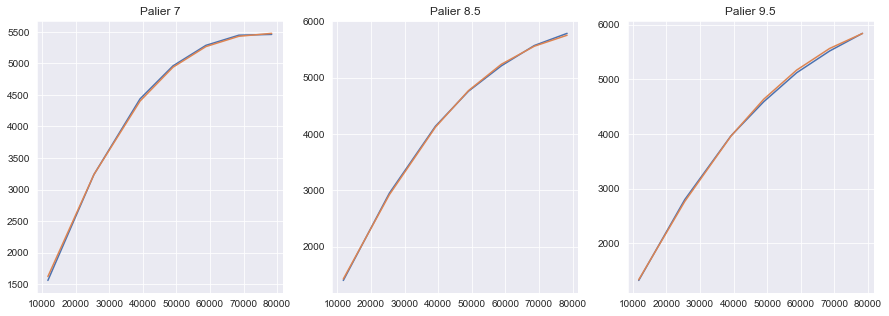

In [40]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

o = [7,8.5,9.5]

seaborn.set({"figure.figsize": (15, 5)})
for palier in range(3):
    pylab.subplot(1,3,palier+1)
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y3[7*palier:7*(palier+1)])
    plt.title(f"Palier {o[palier]}")
plt.show()

In [37]:
print("L'erreur est de ", mean_squared_error(dz, y3))

L'erreur est de  871.2247929740186


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

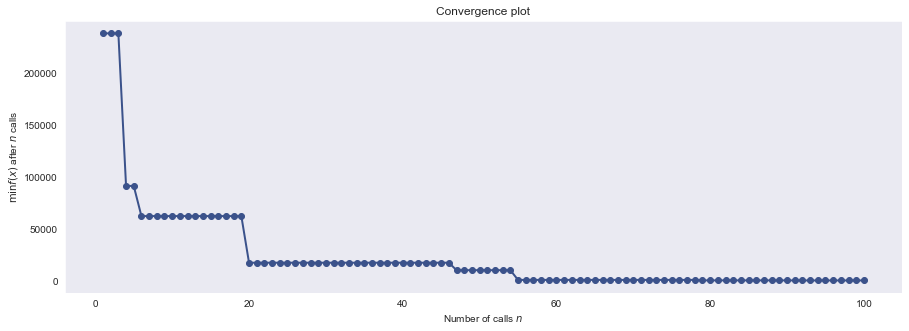

In [39]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(res)

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{4}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>, <AxesSubplot:xlabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{3}$'>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='Partial dependence'>]],
      dtype=object)

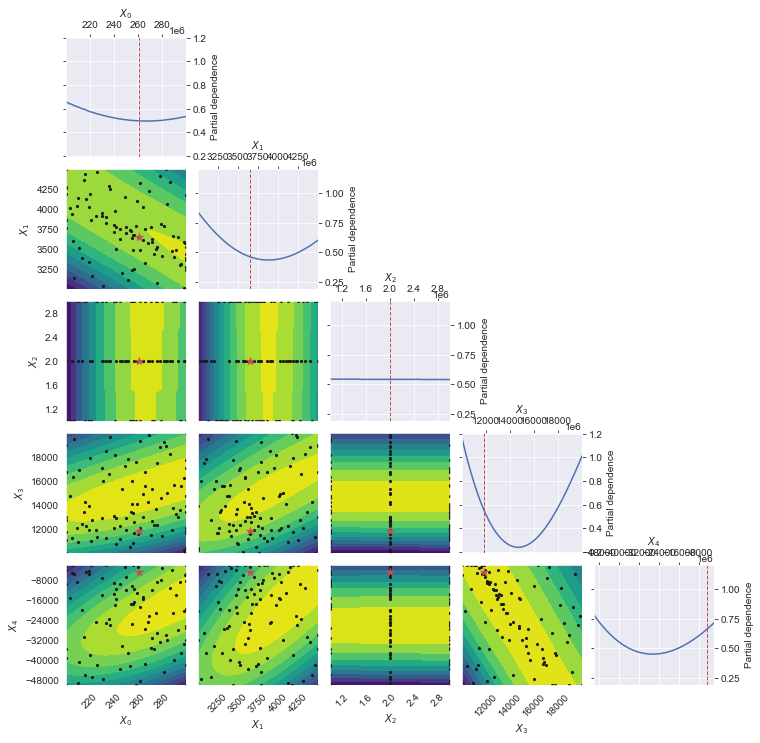

In [56]:
plot_objective(res)

### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?

In [57]:
# Estimation des paramètres par optimisation bayesienne

list_optim = []

for acq_func in ["EI", "PI", "LCB", "gp_hedge"]:
    for n_random_starts in [2**4,2**5,2**6, 2**7]:
        list_optim.append(gp_minimize(func = objective, # the function to minimize
          dimensions = bounds,      # the bounds on each dimension of x
          acq_func=acq_func,      # the acquisition function
          n_calls=150,         # the number of evaluations of f
          n_random_starts=n_random_starts,  # the number of random initialization points
          random_state=42, 
          initial_point_generator = "lhs"))   # the random seed

### Analyse par rapport à la fonction d'acquisition

In [61]:
function_acquisition = ["EI"]*4 + ["PI"]*4 + ["LCB"]*4 + ["gp_hedge"]*4

In [59]:
print(len(list_optim))

16


fonction d'acquisition : EI


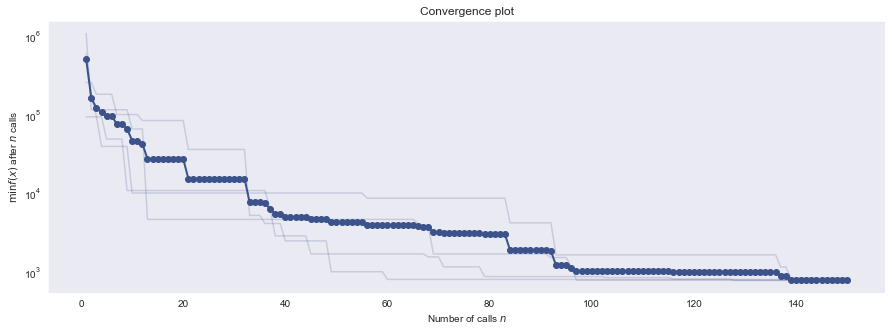

fonction d'acquisition : PI


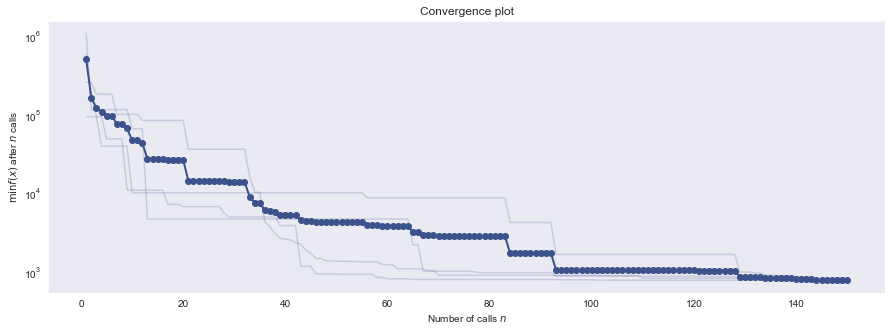

fonction d'acquisition : LCB


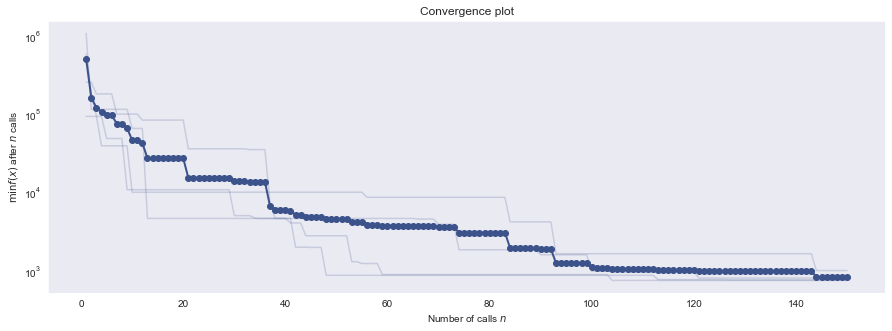

fonction d'acquisition : gp_hedge


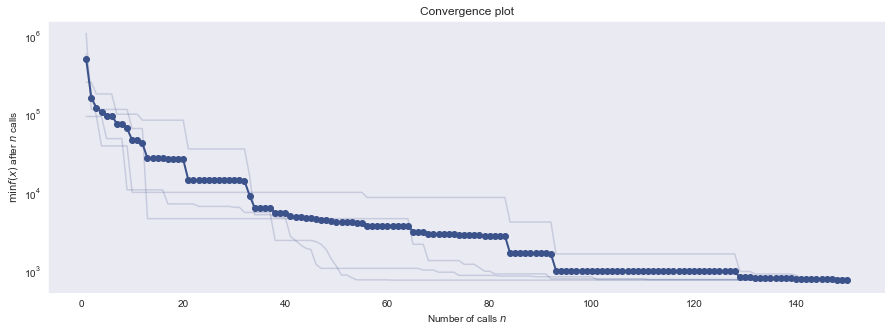

In [60]:
print("fonction d'acquisition : EI")
plot_convergence(list_optim[:4], yscale = "log")
plt.show()

print("fonction d'acquisition : PI")
plot_convergence(list_optim[4:8], yscale = "log")
plt.show()

print("fonction d'acquisition : LCB")
plot_convergence(list_optim[8:12], yscale = "log")
plt.show()

print("fonction d'acquisition : gp_hedge")
plot_convergence(list_optim[12:], yscale = "log")
plt.show()

nombre de points d'évaluation : 16


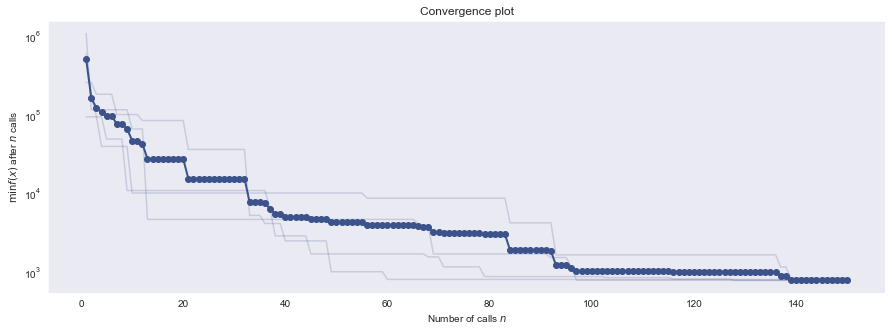

nombre de points d'évaluation : 32


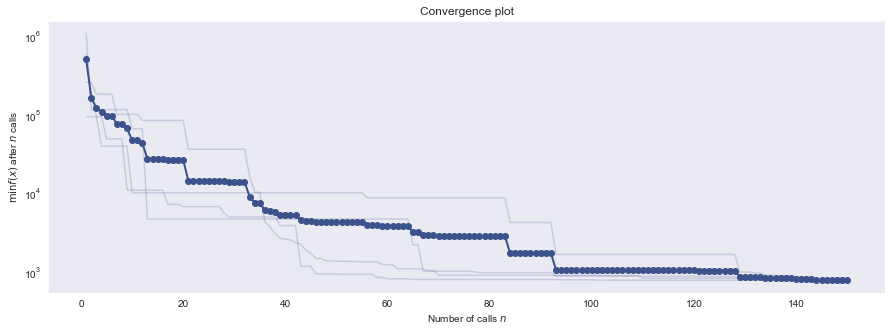

nombre de points d'évaluation : 64


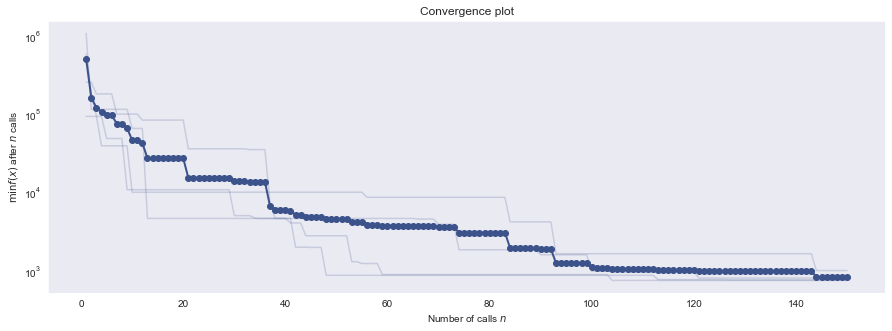

nombre de points d'évaluation : 128


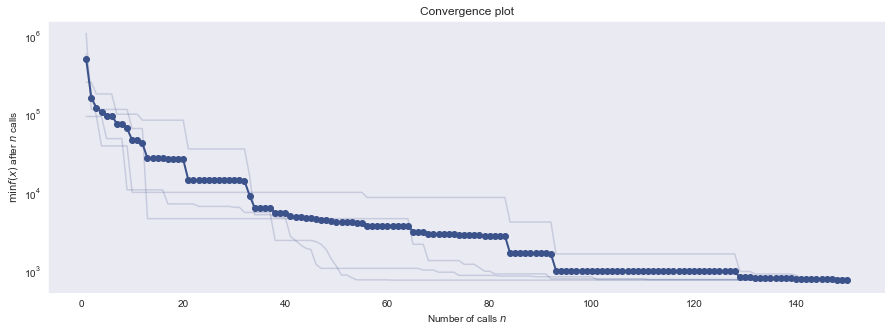

In [61]:
print("nombre de points d'évaluation : 16")
plot_convergence(list_optim[:4] + list_optim[16:16+4] + list_optim[32:32+4]+ list_optim[48:48+4], yscale = "log")
plt.show()

print("nombre de points d'évaluation : 32")
plot_convergence(list_optim[4:8] + list_optim[16 + 4 :16+8] + list_optim[32 + 4:32+8]+ list_optim[48 + 4:48+8], yscale = "log")
plt.show()

print("nombre de points d'évaluation : 64")
plot_convergence(list_optim[8:12] + list_optim[16 + 8:16+12] + list_optim[32 + 8:32+12]+ list_optim[48 + 8:48+12], yscale = "log")
plt.show()

print("nombre de points d'évaluation : 128")
plot_convergence(list_optim[12:16] + list_optim[16 + 12:16+16] + list_optim[32 + 12:32+16]+ list_optim[48 + 12:48+16], yscale = "log")
plt.show()

### On peut voir que le nombre de point d'évaluation impacte autant que la fonction d'acquisition

In [62]:
import pandas as pd

In [63]:
# Create DataFrame
df = pd.DataFrame(columns=['acq_func', 'n_random_starts', 'model'])

In [65]:
count = 0
for acq_func in ["EI", "PI", "LCB", "gp_hedge"]:
    for n_random_starts in [2**4,2**5,2**6, 2**7]:
        df = df.append({'acq_func' : acq_func ,'n_random_starts' : n_random_starts,
                            'model' : list_optim[count]},
                           ignore_index=True)
        count += 1

In [66]:
df.head()

,acq_func,n_random_starts,model
0,EI,16,"{'x': [242, 3813, 2, 11774.603666517449, -4421..."
1,EI,32,"{'x': [252, 3743, 1, 11912.99261406616, -5080...."
2,EI,64,"{'x': [250, 3727, 2, 12042.93028895451, -6992...."
3,EI,128,"{'x': [268, 3617, 3, 12352.831667069886, -8641..."
4,PI,16,"{'x': [255, 3694, 3, 12200.905408712339, -8115..."


In [67]:
df["mse"] = [mean_squared_error(dz,pacejka([p,z], res.x[0],res.x[1], res.x[2], res.x[3], res.x[4])) for res in list_optim]

In [68]:
df.head()

,acq_func,n_random_starts,model,mse
0,EI,16,"{'x': [242, 3813, 2, 11774.603666517449, -4421...",795.871478
1,EI,32,"{'x': [252, 3743, 1, 11912.99261406616, -5080....",818.092235
2,EI,64,"{'x': [250, 3727, 2, 12042.93028895451, -6992....",801.064071
3,EI,128,"{'x': [268, 3617, 3, 12352.831667069886, -8641...",851.566198
4,PI,16,"{'x': [255, 3694, 3, 12200.905408712339, -8115...",785.394645


acq_func
EI          AxesSubplot(0.125,0.125;0.775x0.755)
LCB         AxesSubplot(0.125,0.125;0.775x0.755)
PI          AxesSubplot(0.125,0.125;0.775x0.755)
gp_hedge    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mse, dtype: object

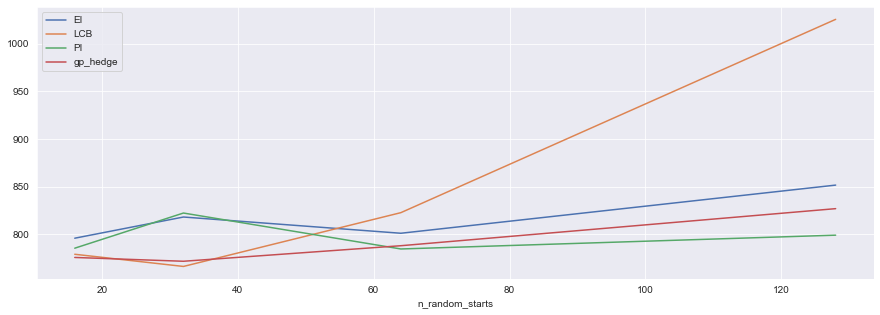

In [70]:
df.set_index('n_random_starts', inplace=True)
df.groupby('acq_func')['mse'].plot(legend=True)

### EI et PI fournissent les résultats les plus stables avec beaucoup de points de générations alors que LCB et GP_hedge sont plus performant avec moins de points

### Comme le suggère la convergence, le nombre de points optimales pour la génération se trouve autour de 32.

    ### Le LCB semble être la meilleur fonction avec un petit nombre de génération

In [78]:
# Estimation des paramètres par optimisation bayesienne

list_optim2 = []

for n_random_starts in np.linspace(20, 40, 21, dtype = int):
        list_optim2.append(gp_minimize(func = objective,                  # the function to minimize
          dimensions = bounds,      # the bounds on each dimension of x
          acq_func="LCB",      # the acquisition function
          n_calls=100,         # the number of evaluations of f
          n_random_starts=n_random_starts,  # the number of random initialization points
          random_state=42, 
          initial_point_generator = "lhs"))   # the random seed

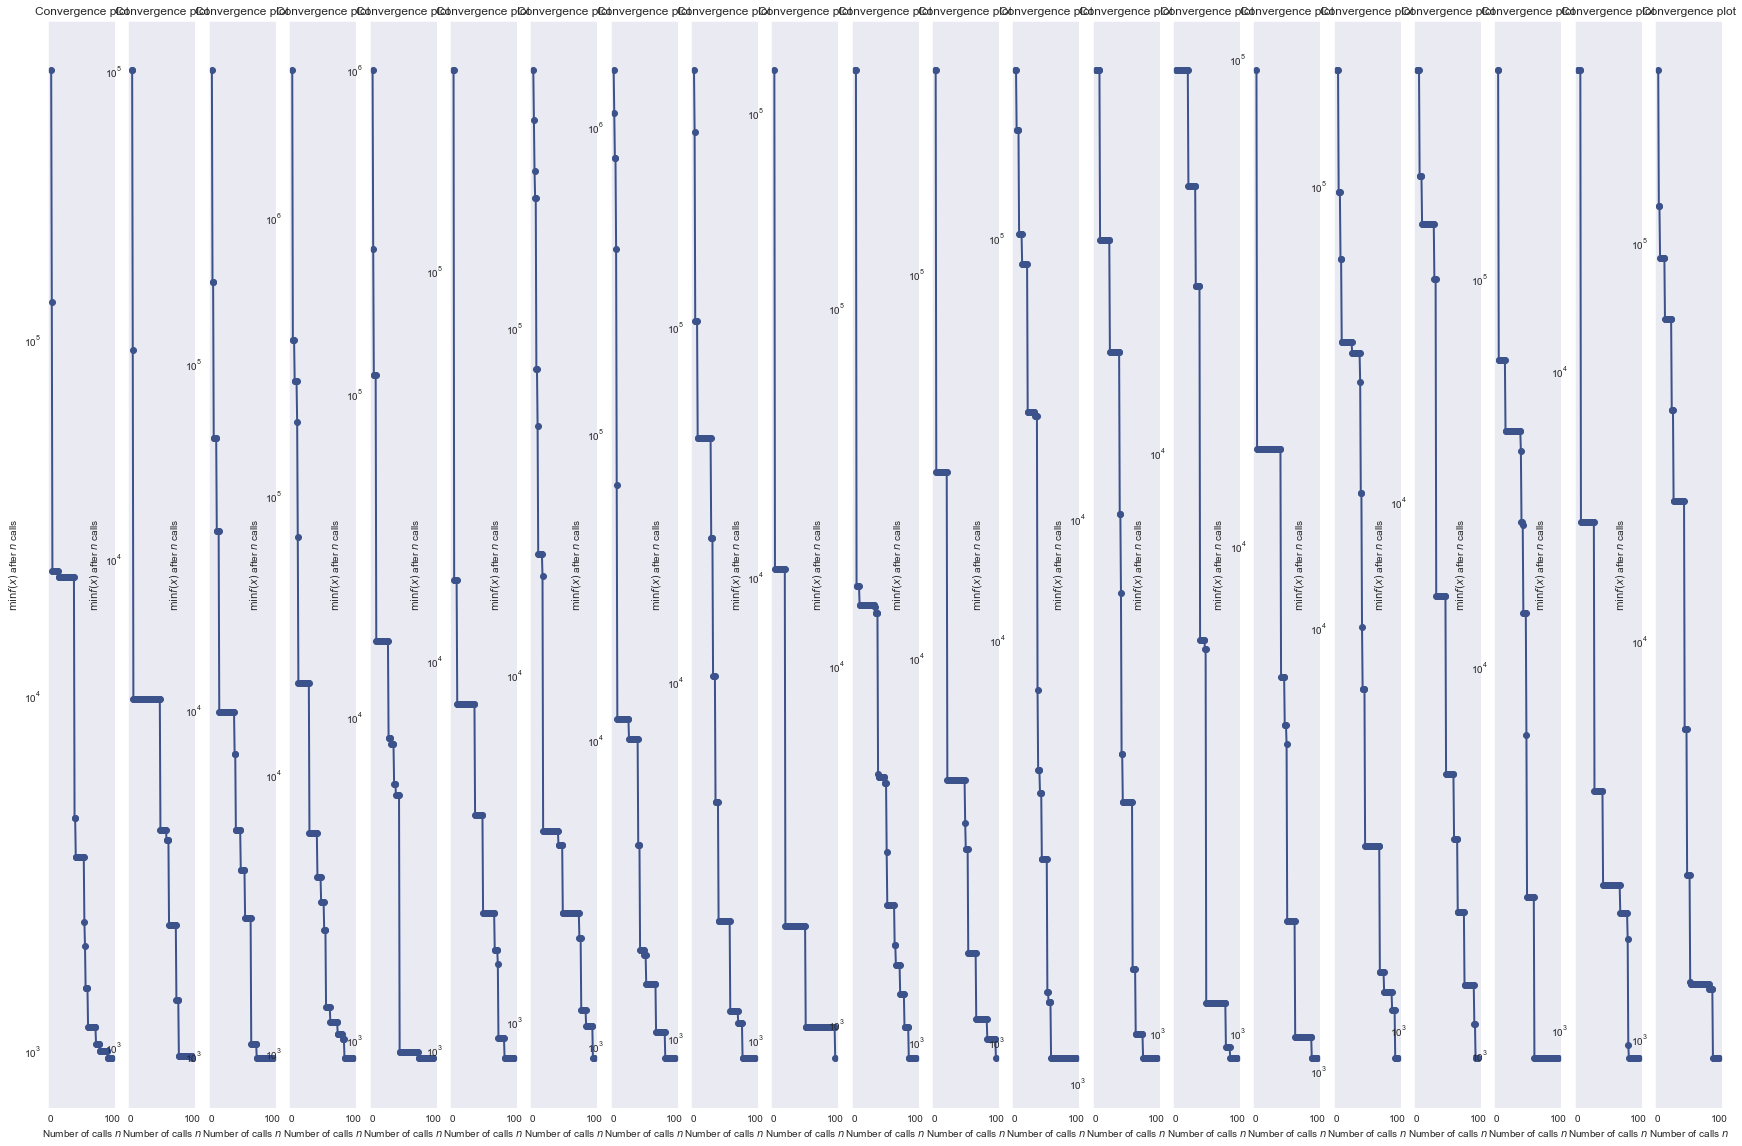

In [79]:
seaborn.set({"figure.figsize": (30, 20)})
for count, elem in enumerate(list_optim2):
    pylab.subplot(1,21,count+1)
    if count == 0:
        ax = plot_convergence(elem, yscale = "log")
    else:
        plot_convergence(elem, yscale = "log", sharey = ax)
plt.show()

In [80]:
mse = [mean_squared_error(dz,pacejka([p,z], res.x[0],res.x[1], res.x[2], res.x[3], res.x[4])) for res in list_optim2]

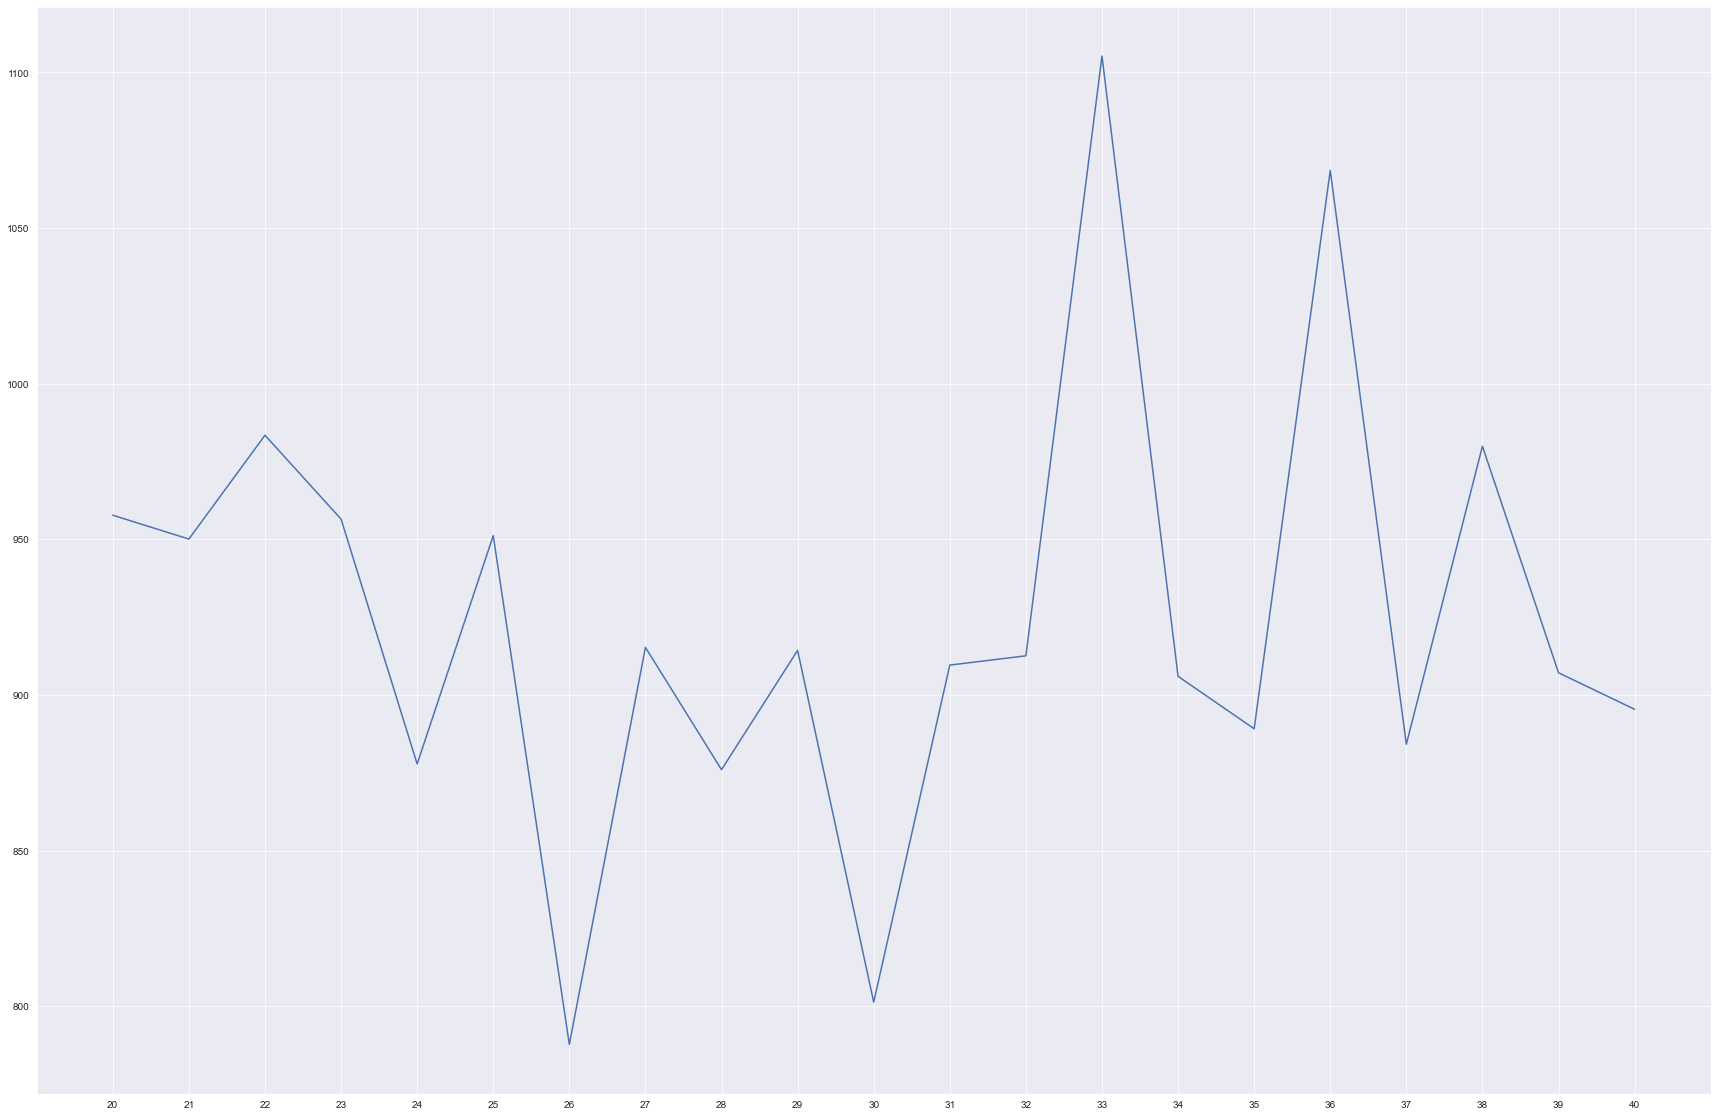

In [81]:
plt.plot(np.linspace(20, 40, 21, dtype = int), mse)
plt.xticks(np.linspace(20, 40, 21, dtype = int))
plt.show()

### 26 est le nombre optimal

In [84]:
print("optimized parameters : ", list_optim2[6].x)

optimized parameters :  [235, 3852, 2, 11567.23800044378, -3203.5176542947593]


In [25]:
y4 = pacejka([p,z], 235, 3852, 2, 11567.23800044378, -3203.5176542947593)

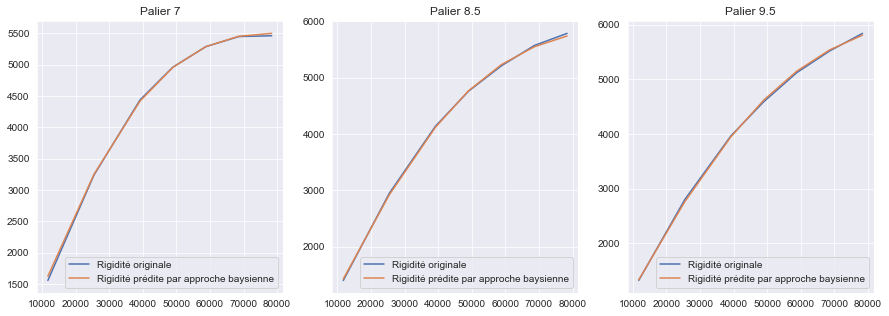

In [44]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

o = [7,8.5,9.5]

seaborn.set({"figure.figsize": (15, 5)})
for palier in range(3):
    pylab.subplot(1,3,palier+1)
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y4[7*palier:7*(palier+1)])
    plt.title(f"Palier {o[palier]}")
    plt.legend(["Rigidité originale", "Rigidité prédite par approche baysienne"])
plt.show()

In [27]:
print("L'erreur est de ", mean_squared_error(dz, y4))

L'erreur est de  787.7264842374196


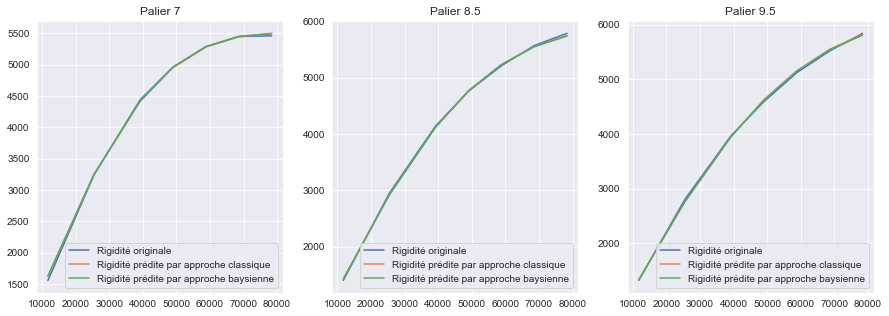

In [43]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

o = [7,8.5,9.5]

seaborn.set({"figure.figsize": (15, 5)})
for palier in range(3):
    pylab.subplot(1,3,palier+1)
    plt.plot(z[7*palier:7*(palier+1)],dz[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y2[7*palier:7*(palier+1)])
    plt.plot(z[7*palier:7*(palier+1)],y4[7*palier:7*(palier+1)])
    plt.title(f"Palier {o[palier]}")
    plt.legend(["Rigidité originale", "Rigidité prédite par approche classique", "Rigidité prédite par approche baysienne"])
plt.show()